$$\sigma_{cfu}^{2}=\sigma_{cfu,fit}^{2}+\sigma_{cfu,OD600}^{2}$$

$$\sigma_{cfu}^{2}\approx\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}+\left(\frac{\partial [cfu/mL]}{\partial [OD600]}\right)^{2}\sigma_{OD600}^{2}$$

$$\sigma_{cfu}^{2}\approx\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}+\left(a(OD600)+b\right)^{2}\left(p(OD600)^{2}+q(OD600)+r\right)$$



In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tfscreen.fitting import (
    run_least_squares,
    predict_with_error
)


def simple_poly(params: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Evaluate a polynomial at specific x values.

    The polynomial is defined by the coefficients in `params`. The function
    assumes the coefficients are ordered from the lowest degree to the highest
    (c_0, c_1, c_2, ...).

    Parameters
    ----------
    params : numpy.ndarray
        An array of polynomial coefficients in order `[c0, c1, c2, ...]`.
        Shape should be 1D. 
    x : numpy.ndarray
        A 1D array of the points at which to evaluate the polynomial(s),
        with shape (N,).

    Returns
    -------
    numpy.ndarray
        A 1D array containing the result of the polynomial evaluation(s).
    """
    
    # Create an exponent for each coefficient row: [0, 1, 2, ...]'
    exponents = np.arange(params.shape[0])
    terms = params[:, np.newaxis] * (x ** exponents[:, np.newaxis])
    
    return np.sum(terms, axis=0)



### OD600 measurment

We need to figure out two things about the OD600 measurement itself. First, what is the detection threshold? Second, what is the spread on replicate measurements? In this, we are going to assume that we remain well below the upper limit of detection. 

In [3]:
# Read in the dataframe with replicate OD600 measurements

df = pd.read_excel("input/Dilution_range_keio_20250917.xlsx",
              sheet_name="1-3dilution",
              header=None,
              names=[f"rep{i}" for i in range(10)])
df["dilution"] = 1/(3**(np.arange(len(df))))
df = df.set_index("dilution")
df

,rep0,rep1,rep2,rep3,rep4,rep5,rep6,rep7,rep8,rep9
dilution,,,,,,,,,,
1.000000,0.5993,0.6060,0.5971,0.5928,0.5954,0.5929,0.5895,0.5906,0.5996,0.5868
0.333333,0.2733,0.2721,0.2705,0.2671,0.2670,0.2660,0.2673,0.2661,0.2655,0.2590
0.111111,0.1505,0.1503,0.1483,0.1471,0.1461,0.1429,0.1430,0.1434,0.1442,0.1431
0.037037,0.1090,0.1113,0.1085,0.1094,0.1111,0.1076,0.1081,0.1106,0.1096,0.1100
0.012346,0.0983,0.0989,0.0969,0.0972,0.0994,0.0960,0.0966,0.0979,0.1003,0.1003
0.004115,0.0949,0.0934,0.0938,0.0933,0.0932,0.0929,0.0927,0.0928,0.0930,0.0928


### Identify detection threshold

Detection threshold is: 0.09573000000000001


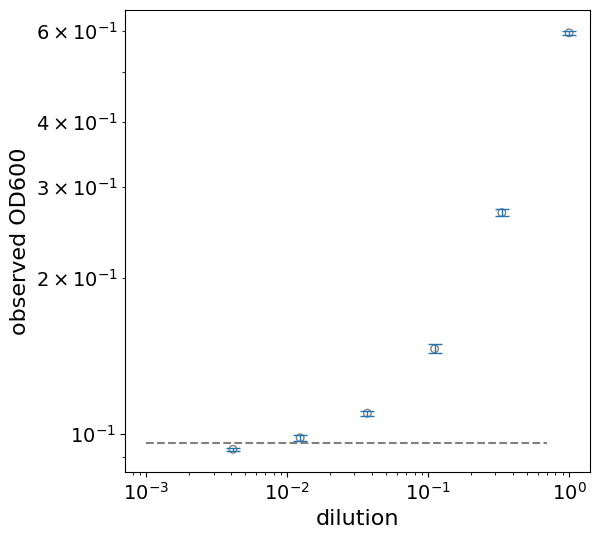

In [4]:
# Get mean and standard deviation from the rows

arr = df.to_numpy()
mu = np.mean(arr,axis=1)
std = np.std(arr,axis=1)

fig, ax = plt.subplots(1,figsize=(6,6))

ax.errorbar(x=df.index,
            y=mu,
            yerr=std,
            elinewidth=1,capsize=5,lw=0)
ax.scatter(x=df.index,
           y=mu,
           s=30,edgecolor="gray",facecolor="none")

od600_meas_threshold = (mu[-2] - mu[-1])/2 + mu[-1]
ax.plot([0.001,0.7],[od600_meas_threshold,od600_meas_threshold],'--',color='gray')
ax.set_xlabel("dilution")
ax.set_ylabel("observed OD600")

ax.set_yscale('log')
ax.set_xscale('log')

# Detection limit is midway between lowest and next-to-lowest point
print(f"Detection threshold is: {od600_meas_threshold}")


### Characterize how the OD600 measurement uncertainty varies with OD600 value

OD600 meas error vs. log(OD600) intercept: 0.0068743731997848775
OD600 meas error vs. log(OD600) slope: 0.0024295904612180188


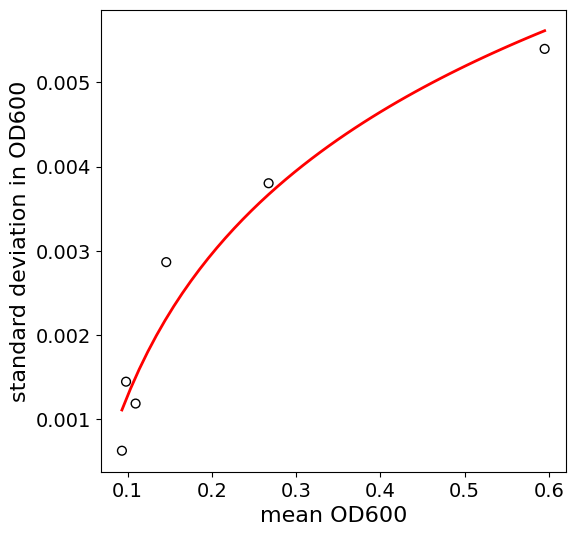

In [5]:
# Error in OD600 is linear in log(OD600). 
fig, ax = plt.subplots(1,figsize=(6,6))

# Fit a line to OD600 measurement uncertainty vs. log(OD600)
p = np.polynomial.Polynomial.fit(np.log(mu),std,deg=1,domain=[])
mu_smooth = np.linspace(np.min(mu),np.max(mu))

# Plot 
ax.scatter(mu,std,s=40,edgecolor="black",facecolor="none")
ax.plot(mu_smooth,p(np.log(mu_smooth)),lw=2,color='red')
ax.set_xlabel("mean OD600")
ax.set_ylabel("standard deviation in OD600")

od600_std_b, od600_std_m = p.coef

print(f"OD600 meas error vs. log(OD600) intercept: {od600_std_b}")
print(f"OD600 meas error vs. log(OD600) slope: {od600_std_m}")


### Get plausible estimate of cfu/mL standard deviation from data

In [6]:
pc_df = pd.read_excel("od600-to-cfu/cfu-od600-calibration.xlsx",sheet_name="platereader_to_cfu")
pc_df

,plate_reader,cfu_per_mL
0,0.5880,485000000
1,0.5299,385000000
2,0.4499,315000000
3,0.3857,244000000
4,0.3386,198000000
5,0.2941,161000000
6,0.2588,146000000
7,0.2267,101000000
8,0.1830,75000000
9,0.1680,68000000


In [7]:
# Extract estimate of cfu_est and a (fake) cfu_std based on counting statistics

pipette_pct_err = 0.02
num_dilutions = 3

fake_counts = pc_df["cfu_per_mL"].to_numpy()/(100**num_dilutions)

od600_est = pc_df["plate_reader"].to_numpy()
cfu_est = fake_counts*(100**num_dilutions)
cfu_std = cfu_est*np.sqrt(1/fake_counts + (num_dilutions + 1)*(pipette_pct_err)**(2))


### Fit a polynomial to cfu/mL vs. OD600

In [8]:
# Get polynomial relating od600_est to cfu_est and cfu_std
params, param_std, cov_matrix, fit = run_least_squares(simple_poly,
                                                       cfu_est,
                                                       cfu_std,
                                                       [1,0,0],
                                                       args=(od600_est,))
print("cfu parameters")
print(params)

cfu parameters
[-3.40617810e+07  4.72324523e+08  6.57171199e+08]


/Users/harmsm/miniconda3/lib/python3.12/site-packages/numpy/_core/numeric.py:476: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


### Fit a polynomial of cfu/mL error to OD600. 

In [9]:

# Using covariance matrix, estimate cfu_pred_std --> the standard error on
# our predicted cfu/mL given the model
od600_smooth = np.linspace(np.min(od600_est)*0.95,np.max(od600_est)*1.05,20)
cfu_pred, cfu_pred_std = predict_with_error(simple_poly,
                                            params,
                                            cov_matrix,
                                            args=(od600_smooth,))

# Create a polynomial of cfu_pred_std vs. od600, allowing us to calculate 
# our cfu_pred_std given od600. 
err_params, _, err_cov_matrix, _ = run_least_squares(simple_poly,
                                                           cfu_pred_std,
                                                           np.full(len(cfu_pred),0.1e7),
                                                           [1,0,0],
                                                           args=(od600_smooth,))

print("err_pred")
print(err_params)

err_pred
[ 2009256.69108424  3767156.77728439 19187416.58649789]


### Final synthesized function

In [14]:

def od600_to_cfu(od600):
    """
    Convert Harms lab plate reader OD600 values to cfu/mL using empirical
    calibration parameters.

    Parameters
    ----------
    od600 : np.ndarray
        array of OD600 measurements

    Returns
    -------
    cfu_est : np.ndarray
        1D array of estimated cfu/mL from OD600
    cfu_std : np.ndarray
        1D array of standard error on the estimated cfu/mL
    detectable : np.ndarray
        1D boolean array indicating whether the OD600 was above the 
        detection threshold. 
    """
    

    # emprically, od600 measurement threshold
    od600_meas_threshold = 0.09573000000000001
    
    # emprical od600 to cfu, 2nd-order polynomial
    a_cfu = -3.40617810e+07
    b_cfu =  4.72324523e+08
    c_cfu =  6.57171199e+08
    
    # empirical cfu standard error vs. od600, 2nd-order polynomial
    a_err = 2009256.69108424
    b_err = 3767156.77728439
    c_err = 19187416.58649789
    
    # empirically, od600 measurement error follows:
    #     ln(od600)*od600_std_m + od600_std_b
    od600_std_m = 0.0024295904612180188
    od600_std_b = 0.0068743731997848775
    
    # see if we are dealing with a single value. Turn into an array for
    # simplicity. 
    single_value = False
    if np.isscalar(od600):
        single_value = True
        od600 = np.array([od600])
    
    # work on a copy
    od600 = od600.copy()
    
    # left-cap values below the measurement threshold
    detectable = np.ones(len(od600),dtype=bool)
    detectable[od600 < od600_meas_threshold] = False
    od600[od600 < od600_meas_threshold] = od600_meas_threshold
        
    # caclulate cfu estimate
    cfu_est = a_cfu + b_cfu*(od600) + c_cfu*(od600**2)
    
    # caclulate (cfu estimate error)^2 from polynomial
    cfu_est_std_2 = (a_err + b_err*(od600) + c_err*(od600**2))**2
    
    # caclulate (dy/dx)^2 of the cfu vs od600 curve
    dy_dx_2 = (b_cfu + 2*c_cfu*od600)**2
    
    # caclulate (error in od600 measurement)^2
    od600_std_2 = (od600_std_m*np.log(od600) + od600_std_b)**2 
    
    # Final cfu_err is square root of combined variances
    cfu_std = np.sqrt(cfu_est_std_2 + dy_dx_2*od600_std_2)
    
    if single_value:
        cfu_est = cfu_est[0]
        cfu_std = cfu_std[0]
        detectable = detectable[0]
    
    return cfu_est, cfu_std, detectable


od600_smooth = np.linspace(0,np.max(od600_est)*1.05,100)

cfu_est_final, cfu_std_final, detectable = od600_to_cfu(od600_smooth)

cfu_est_final/1e6

array([ 17.17631551,  17.17631551,  17.17631551,  17.17631551,
        17.17631551,  17.17631551,  17.17631551,  17.17631551,
        17.17631551,  17.17631551,  17.17631551,  17.17631551,
        17.17631551,  17.17631551,  17.17631551,  17.17631551,
        19.61068539,  23.39971506,  27.23986244,  31.13112753,
        35.07351033,  39.06701084,  43.11162906,  47.20736498,
        51.35421862,  55.55218996,  59.80127901,  64.10148577,
        68.45281024,  72.85525242,  77.3088123 ,  81.8134899 ,
        86.3692852 ,  90.97619821,  95.63422894, 100.34337736,
       105.1036435 , 109.91502735, 114.77752891, 119.69114817,
       124.65588514, 129.67173982, 134.73871221, 139.85680231,
       145.02601012, 150.24633564, 155.51777886, 160.8403398 ,
       166.21401844, 171.63881479, 177.11472885, 182.64176062,
       188.2199101 , 193.84917728, 199.52956218, 205.26106478,
       211.04368509, 216.87742311, 222.76227884, 228.69825228,
       234.68534343, 240.72355228, 246.81287885, 252.95

### Create a plot of results

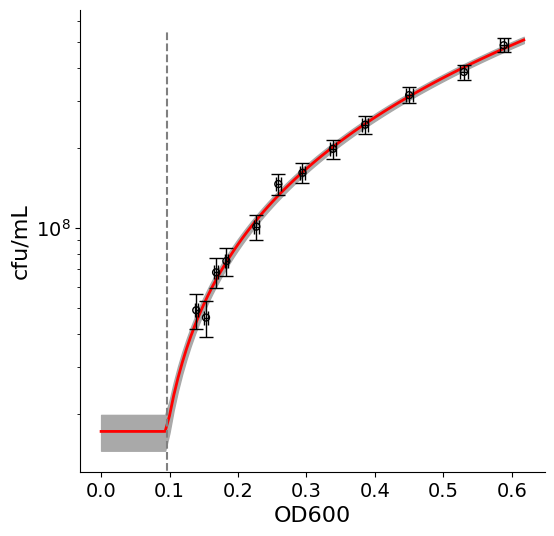

In [11]:

fig, ax = plt.subplots(1,figsize=(6,6))
ax.scatter(od600_est,
           cfu_est,
           s=25,facecolor='none',edgecolor='black',zorder=10)
ax.errorbar(x=od600_est,
            xerr=(od600_std_m*np.log(od600_est) + od600_std_b),
            y=cfu_est,
            yerr=cfu_std,
            lw=0,capsize=5,color='black',elinewidth=1,zorder=10)

ax.plot(od600_smooth,cfu_est_final,'-',color='red',lw=2)
ax.fill_between(od600_smooth,
                cfu_est_final-cfu_std_final,
                cfu_est_final+cfu_std_final,
                color='darkgray',
                zorder=-3)
ax.plot([od600_meas_threshold,od600_meas_threshold],
        [0,5.5e8],'--',color='gray')

ax.set_xlabel("OD600")
ax.set_ylabel("cfu/mL")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yscale("log")
